# Cross-validation for parameter tuning, model selection, and feature selection ([video #7](https://www.youtube.com/watch?v=6dbrR-WymjI&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=7))

Created by [Data School](http://www.dataschool.io/). Watch all 9 videos on [YouTube](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A). Download the notebooks from [GitHub](https://github.com/justmarkham/scikit-learn-videos).

**Note:** This notebook uses Python 3.6 and scikit-learn 0.19.1. The original notebook (shown in the video) used Python 2.7 and scikit-learn 0.16, and can be downloaded from the [archive branch](https://github.com/justmarkham/scikit-learn-videos/tree/archive).

## Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [3]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

In [4]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9736842105263158


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

In [5]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [6]:
from sklearn.model_selection import cross_val_score

In [7]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]


In [8]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.9666666666666668


In [9]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.96, 0.9533333333333334, 0.9666666666666666, 0.9666666666666666, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9800000000000001, 0.9666666666666666, 0.9666666666666666, 0.9733333333333334, 0.96, 0.9666666666666666, 0.96, 0.9666666666666666, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334]


Text(0,0.5,'Cross-Validated Accuracy')

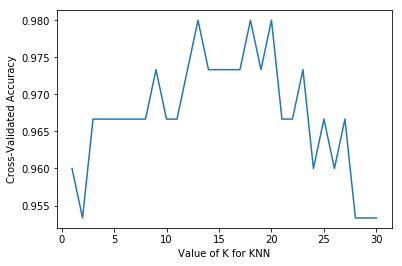

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Cross-validation example: model selection

**Goal:** Compare the best KNN model with logistic regression on the iris dataset

In [11]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.9800000000000001


In [12]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9533333333333334


## Cross-validation example: feature selection

**Goal**: Select whether the Newspaper feature should be included in the linear regression model on the advertising dataset

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [14]:
# read in the advertising dataset
data = pd.read_csv('data/Advertising.csv', index_col=0)

In [15]:
# create a Python list of three feature names
feature_cols = ['TV', 'Radio', 'Newspaper']

# use the list to select a subset of the DataFrame (X)
X = data[feature_cols]

# select the Sales column as the response (y)
y = data.Sales

In [16]:
# 10-fold cross-validation with all three features
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')
print(scores)

[-3.56038438 -3.29767522 -2.08943356 -2.82474283 -1.3027754  -1.74163618
 -8.17338214 -2.11409746 -3.04273109 -2.45281793]


In [17]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[3.56038438 3.29767522 2.08943356 2.82474283 1.3027754  1.74163618
 8.17338214 2.11409746 3.04273109 2.45281793]


In [18]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)

[1.88689808 1.81595022 1.44548731 1.68069713 1.14139187 1.31971064
 2.85891276 1.45399362 1.7443426  1.56614748]


In [19]:
# calculate the average RMSE
print(rmse_scores.mean())

1.6913531708051797


In [20]:
# 10-fold cross-validation with two features (excluding Newspaper)
feature_cols = ['TV', 'Radio']
X = data[feature_cols]
print(np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

1.6796748419090768


## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

## Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- scikit-learn issue on GitHub: [MSE is negative when returned by cross_val_score](https://github.com/scikit-learn/scikit-learn/issues/2439)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

## Comments or Questions?

- Email: <kevin@dataschool.io>
- Website: http://dataschool.io
- Twitter: [@justmarkham](https://twitter.com/justmarkham)

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()